In [2]:
import matplotlib.pyplot as plt
import numpy as np

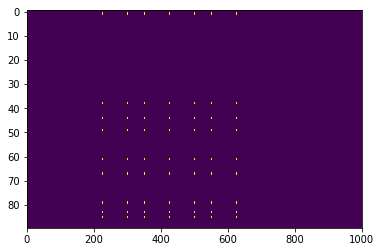

In [3]:
def generatePNStim(total,start,end,freq,fraction):
    train = np.zeros(total)
    for i in range(start,end,int(1000/freq)):
        train[i] = 1
    active = [1]*int(fraction*90)+[0]*(90-int(fraction*90))
    np.random.shuffle(active)
    data = np.zeros((90,total))
    for i in range(90):
        data[i,:] = active[i]*train
    return data
    
plt.imshow(generatePNStim(1000,200,700,40,0.1),aspect='auto');

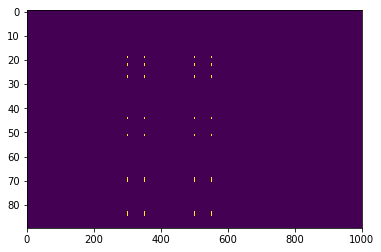

In [4]:
pn_spikes = generatePNStim(1000,200,700,20,0.1).T
plt.imshow(pn_spikes.T,aspect='auto');

duration = pn_spikes.shape[0]
resolution =1

n_KC = 15000
n_PN = pn_spikes.shape[1]

#np.zeros((int(duration/resolution),n_PN))
#pn_spikes[:,:int(0.1*n_PN)] = np.random.choice([0,1],size=(int(duration/resolution),int(0.1*n_PN)),p=[0.9999,0.0001])

In [5]:
pn_spikes_dec = np.int32(np.sum(np.vsplit(pn_spikes,int(pn_spikes.shape[0]*resolution)),axis=1)>0)

In [6]:
cmatrix = np.random.choice([1,0],size=(n_KC,n_PN),p=[0.5,0.5])

In [37]:
u = 0.0012 + np.random.uniform(-0.00068,0.00068,n_KC)
Be = 0.03
sigma = 0.06 + np.random.exponential(0.0072,n_KC)
sigmae = 1
alpha= 3.65

x_KC = (sigma-1)*np.ones((int(duration)+2,n_KC))
y_KC = x_KC - alpha/(1-x_KC)

n_syn = np.sum(cmatrix)
g_PNKC = np.zeros((int(duration)+2,n_syn))
I_PNKC = np.zeros((int(duration)+2,n_KC))
gamma = 0.4
G_PNKC = 0.0000066
S_den = 165e-6

E_ach = 0

def f_alpha(xn,xnm1,u):
    return np.where(xn <=0, alpha/(1-xn)+ u, np.where(np.logical_and(xnm1<=0,xn<alpha+u),alpha+u,-np.ones(n_KC)) )


u_ggn = 0.05
sigma_ggn = -0.5
alpha_ggn = 0.8

def ggn_f(xn):
    return np.where(xn<-3,-2,np.where(xn>3,2,xn-xn**3/27))

x_GGN = (sigma_ggn-1)*np.ones(int(duration)+2)
y_GGN = alpha_ggn*(x_GGN - x_GGN**3/27) - x_GGN

g_KCGGN = np.zeros((int(duration)+2,n_KC))
I_KCGGN = np.zeros(int(duration)+2)
G_KCGGN = 0.05

g_GGNKC = np.zeros((int(duration)+2,n_KC))
I_GGNKC = np.zeros((int(duration)+2,n_KC))
G_GGNKC = 0.00004
E_gaba = -0.7
for i in range(2,x_KC.shape[0]):
    print("{}/{}".format(i,x_KC.shape[0]),end='\r')
    
    g_PNKC[i,:] = gamma*g_PNKC[i-1,:] + G_PNKC/S_den * (cmatrix*pn_spikes_dec[i-2,:])[cmatrix>0]
    
    I_PNKC_t = np.float64(np.copy(cmatrix))
    np.putmask(I_PNKC_t,cmatrix>0,g_PNKC[i-1,:])
#     I_PNKC[i,:] = (-I_PNKC_t.T*(x_KC[i-1,:]-E_ach)).sum(axis=0)
    I_PNKC[i,:] = (-I_PNKC_t.T*(((x_KC[i-1,:]-E_ach)<0)*(x_KC[i-1,:]-E_ach))).sum(axis=0)
    
    x_KC[i,:] = f_alpha(x_KC[i-1,:],x_KC[i-2,:],y_KC[i-1,:]+Be*(I_PNKC[i-1,:]+I_GGNKC[i-1,:]))
    y_KC[i,:] = y_KC[i-1,:] - u*(1+x_KC[i-1,:]) + u*(sigma+sigmae*I_PNKC[i-1,:])
    
    spiking = np.logical_or(x_KC[i-1,:]>=alpha+y_KC[i-1,:]+Be*I_PNKC[i,:],x_KC[i-2,:]>0)
    
    g_KCGGN[i,:] = gamma*g_KCGGN[i-1,:] + G_KCGGN * spiking
    
    I_KCGGN[i] = -np.sum(g_KCGGN[i,:]*((x_GGN[i]-E_ach)*(x_GGN[i]-E_ach<0)))
#     I_KCGGN[i] = np.sum(g_KCGGN[i,:]*(x_GGN[i]-E_ach))
    
    x_GGN[i] = alpha_ggn*ggn_f(x_GGN[i-1]) - y_GGN[i-1]
    y_GGN[i] = y_GGN[i-1] + u_ggn*(1+x_GGN[i-1]) - u_ggn*(sigma_ggn+sigmae*I_KCGGN[i])
    
    g_GGNKC[i,:] = gamma*g_GGNKC[i-1,:] + (x_GGN[i-1]>1.4)*(1/(1+np.exp(1-x_GGN[i-1]/1.5)*G_GGNKC/S_den))
    I_GGNKC[i,:] = -g_GGNKC[i-1,:]*(x_KC[i-1,:]-E_gaba)#*0
    

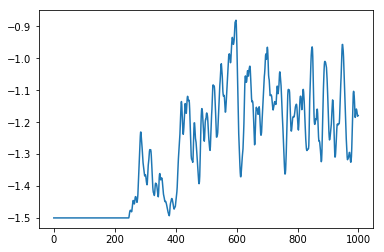

In [38]:
plt.plot(x_GGN[:1000])
#plt.plot(I_KCGGN[:2000])
#plt.plot(g_KCGGN[:,:].sum(axis=1))
#plt.plot(((x_GGN[:2000]-E_ach)))

(90, 2)
(809, 2)


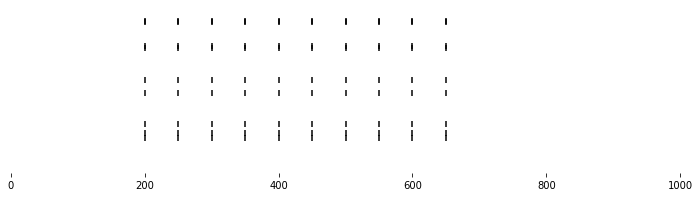

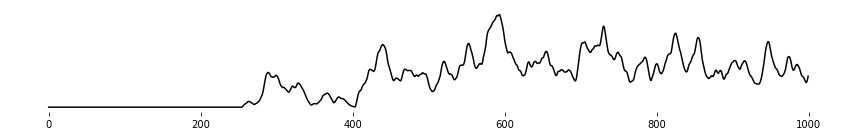

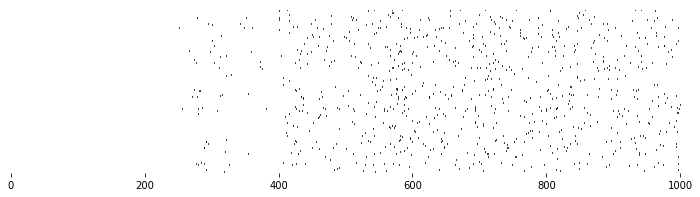

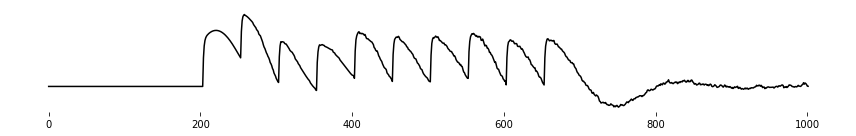

In [34]:
plt.figure(figsize=(12,3))
ax = plt.subplot(111)   
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)    
#plt.xticks([])
plt.yticks([])
lol = pn_spikes_dec>0
events = []
for j in range(1000):
    for k in range(90):
        if lol[j,k]:
                events.append((j,k))
events = np.array(events)
print(events.shape)
plt.scatter(events[:,0],events[:,1],marker='|',c='k')
plt.xlim([0,1000])
plt.ylim([0,90])

plt.figure(figsize=(12,2))
ax = plt.subplot(111)   
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)    
#plt.xticks([])
plt.yticks([])
#plt.xlim([0,4000])
#plt.ylim([0,30])    
plt.plot(x_GGN[:1000],'k')
plt.tight_layout()

plt.figure(figsize=(12,3))
ax = plt.subplot(111)   
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)    
#plt.xticks([])
plt.yticks([])
#plt.xlim([0,4000])
#plt.ylim([0,30])    
#plt.imshow(,aspect='auto',cmap='gray_r')
lol = np.logical_and(x_KC.T[:,1:]>0,x_KC.T[:,:-1]<0)
events = []
for j in range(15000):
    for k in range(1000):
        if lol[j,k]:
                events.append((j,k))
events = np.array(events)
print(events.shape)
plt.scatter(events[:,1],events[:,0],marker='_',s=1.0,c='k',alpha=1)
plt.xlim([0,1000])
plt.ylim([0,15000])

plt.figure(figsize=(12,2))
ax = plt.subplot(111)   
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)    
#plt.xticks([])
plt.yticks([])
#plt.xlim([0,4000])
#plt.ylim([0,30])    
plt.plot(x_KC.mean(axis=1),'k')
plt.tight_layout()


(200, 500)

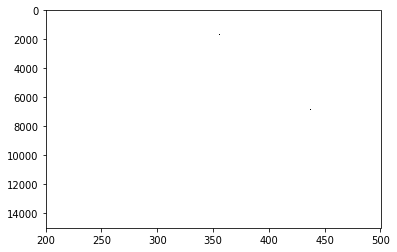

In [35]:
plt.imshow(plt.np.logical_and(x_KC.T[:,1:]>0,x_KC.T[:,:-1]<0),aspect='auto',cmap='gray_r')
plt.xlim([200,500])

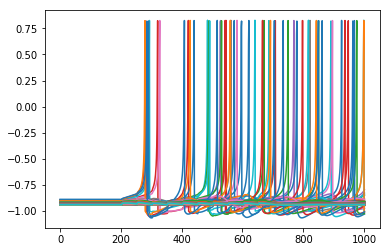

In [36]:
plt.plot(x_KC[:,:1000]);

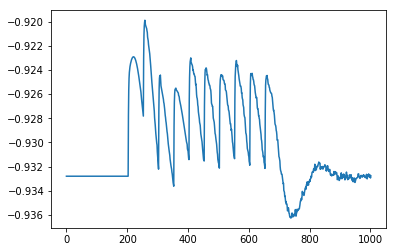

In [20]:
plt.plot(x_KC.mean(axis=1))